# Conditional Volatility

- Value at Risk, GARCH, EWMA, Scholes-Williams Beta
- VIX, Bitcoin, St Louis Fed FRED

Terence Lim

In [1]:
import os
import numpy as np
import scipy
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns 
from finds.alfred import Alfred

from settings import settings
imgdir = os.path.join(settings['images'], 'ts')
alf = Alfred(api_key=settings['fred']['api_key'])


## Helpers for VaR tests

In [2]:
# proportion of failures likelihood test
def kupiecLR(s, n, var):
    """Kupiec LR test (S violations in N trials) of VaR"""
    p = 1 - var        # e.g. var95 is 0.95
    t = n - s          # number of non-violations
    num = np.log(1 - p)*(n - s) + np.log(p)*s
    den = np.log(1 - (s/n))*(n - s) + np.log(s/n)*s
    lr = -2 * (num - den)
    return {'lr': lr, 'pvalue': 1 - scipy.stats.chi2.cdf(lr, df=1)}

def pof(X, pred, var=0.95):
    """Kupiec proportion of failures VaR test"""
    Z = X / pred
    z = scipy.stats.norm.ppf(1 - var)
    r = {'n': len(Z), 's': np.sum(Z < z)}
    r.update(kupiecLR(r['s'], r['n'], var))
    return r

# convert alpha to halflife
from pandas.api import types
def halflife(alpha):
    """Returns halflife from alpha = -ln(2)/ln(lambda), where lambda=1-alpha"""
    if types.is_list_like(alpha):
        return [halflife(a) for a in alpha]
    return -np.log(2)/np.log(1-alpha) if 0<alpha<1 else [np.inf,0][int(alpha>0)]

## Retrieve Bitcoin from FRED and plot EWMA and Daily Returns

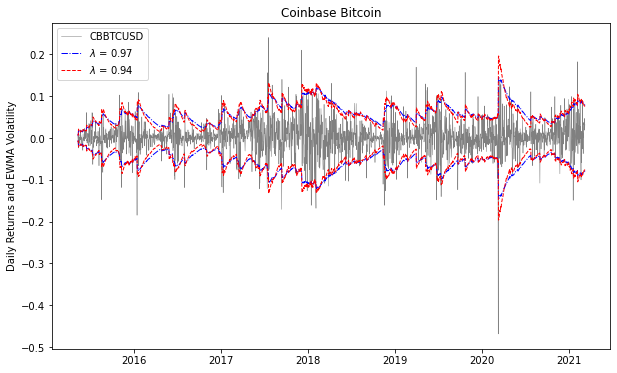

In [3]:
z = scipy.stats.norm.ppf(0.05)
alpha = [0.03, 0.06]
series_id = 'CBBTCUSD'
X = alf(series_id, log=1, diff=1)[126:]
X.index = pd.DatetimeIndex(X.index.astype(str), freq='infer')
Y = np.square(X)
ewma = [np.sqrt((Y.ewm(alpha=a).mean()).rename(series_id)) for a in alpha]
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
ax.plot(X.shift(-1), ls='-', lw=.5, c='grey')
ax.plot(z * ewma[0], lw=1, ls='-.', c='b')
ax.plot(z * ewma[1], lw=1, ls='--', c='r')
ax.set_title(alf.header(series_id))
ax.set_ylabel('Daily Returns and EWMA Volatility')
ax.legend([series_id] + [f"$\lambda$ = {1-a:.2f}" for a in alpha])
ax.plot(-z * ewma[0], lw=1, ls='-.', c='b')
ax.plot(-z * ewma[1], lw=1, ls='--', c='r')
plt.savefig(os.path.join(imgdir, 'ewma.jpg'))
plt.show()

In [4]:
## Retrieve SP500 and VIX data, compute EWMA

In [5]:
sp500 = alf('SP500', log=1, diff=1).dropna()
vix = alf('VIXCLS')
ewma = np.sqrt((np.square(sp500).ewm(alpha=0.05).mean()).rename('EWMA(0.94)'))
mkt = pd.concat([sp500, ewma, (vix/100)/np.sqrt(252)], axis=1, join='inner')
mkt.index = pd.DatetimeIndex(mkt.index.astype(str), freq='infer')
mkt

,SP500,EWMA(0.94),VIXCLS
date,,,
2011-03-15,-0.011264,0.011264,0.015320
2011-03-16,-0.019687,0.016142,0.018520
2011-03-17,0.013309,0.015209,0.016612
2011-03-18,0.004293,0.013189,0.015396
2011-03-21,0.014882,0.013581,0.012983
...,...,...,...
2021-03-04,-0.013508,0.010921,0.017997
2021-03-05,0.019308,0.011487,0.015534
2021-03-08,-0.005374,0.011260,0.016045


## GARCH(1,1) using rugarch


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(2,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000816    0.000112   7.3115 0.000000
ar1    -0.066110    0.022580  -2.9278 0.003413
ar2     0.022196    0.021454   1.0346 0.300866
omega   0.000004    0.000002   2.1419 0.032204
alpha1  0.218600    0.011632  18.7924 0.000000
beta1   0.748534    0.002150 348.1085 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000816    0.000419  1.94560 0.051703
ar1    -0.066110    0.021508 -3.07370 0.002114
ar2     0.022196    0.028794  0.77083 0.440807
omega   0.000004    0.000013  0.32900 0.742154
alpha1  0.218600    0.099536  2.19620 0.028078
beta1   0.748534    0.110271  6.78815 0.000000

LogLike

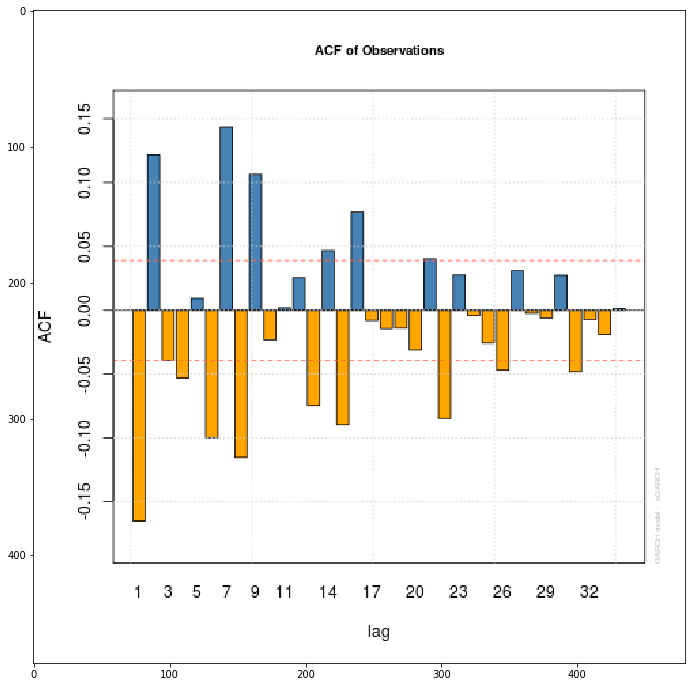

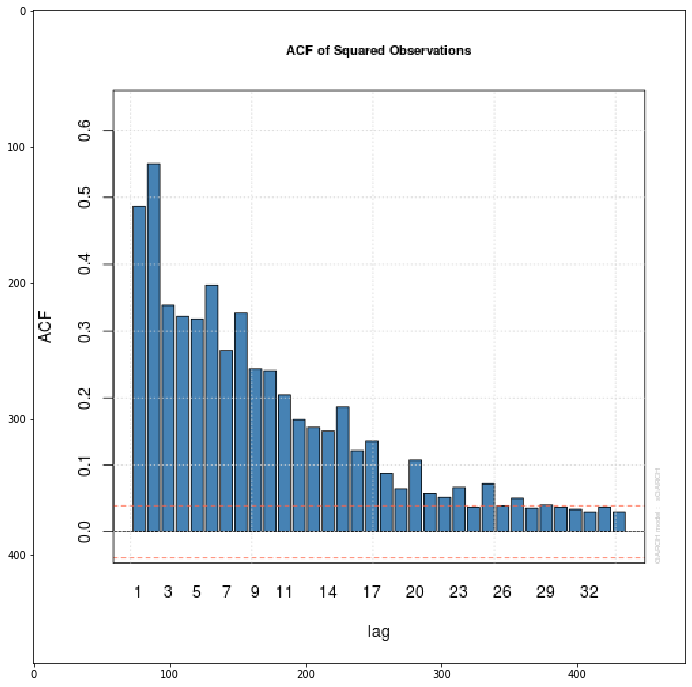

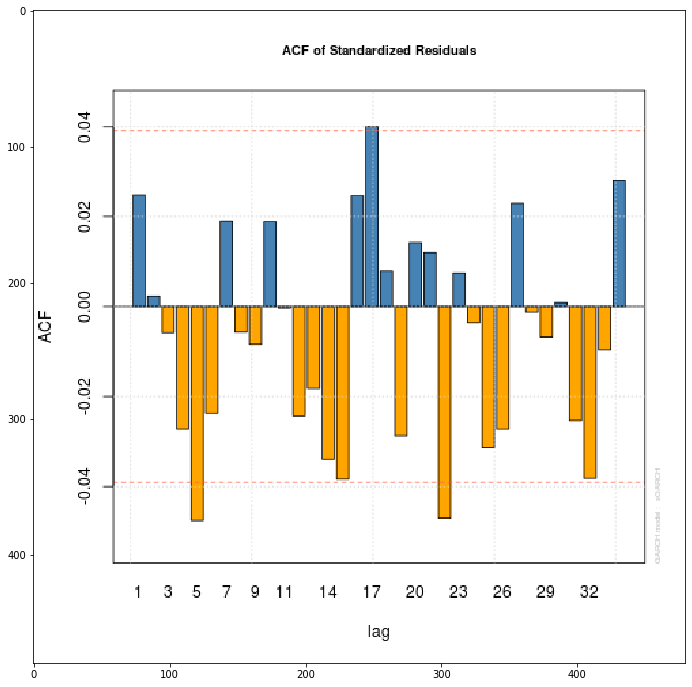

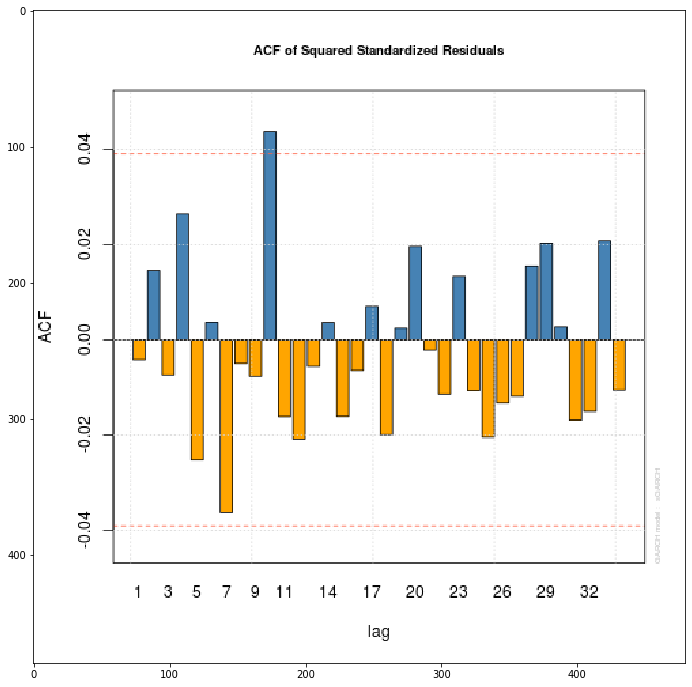

In [6]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.pyR import PyR
rugarch_ro = importr('rugarch')  # to use library rugarch
c_ = ro.r['c']
list_ = ro.r['list']
spec = ro.r['ugarchspec'](mean_model=list_(armaOrder=c_(2,0),include_mean=False))
model = ro.r['ugarchfit'](spec, data=PyR(mkt['SP500'].values).ro) 
ro.r['show'](model)
for which in [4, 5, 10, 11]:
    ro.r['plot'](model, which=which)
    PyR.savefig(os.path.join(imgdir, f'ugarch{which}.png'))

# Plot all, but for illustration only: 
## The 3 "forecasts" are not comparable: VIX is implied from options with 3-month expiry, GARCH fitted fully in-sample, EWMA is rolling average

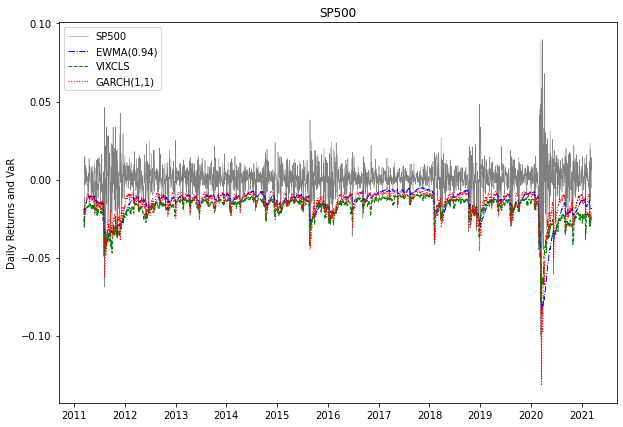

In [7]:
mkt['GARCH(1,1)'] = PyR(ro.r['sigma'](model)).values  # fitted volatility values
var = 0.95   # VaR95
z = scipy.stats.norm.ppf(1 - var)
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,7))
ax.plot(mkt['SP500'], ls='-', lw=.5, c='grey')
ax.plot(z * mkt.iloc[:,1], lw=1, ls='-.', c='blue')
ax.plot(z * mkt.iloc[:,2], lw=1, ls='--', c='green')
ax.plot(z * mkt.iloc[:,3], lw=1, ls=':', c='red')
ax.set_title('SP500')
ax.set_ylabel('Daily Returns and VaR')
ax.legend(mkt.columns)
plt.savefig(os.path.join(imgdir, 'var.jpg'))
plt.show()

# Get all daily series of financial price categories from FRED


In [8]:
categories = {}
for category in [32255, 33913, 94]:
    c = alf.get_category(category)
    print(category, c['id'], c['name'])
    series = Series({s['id']: s['title'] for s in c['series']
                     if s['frequency'].startswith('Daily') and 'DISCONT' not in s['title']})
    categories.update({c['name']: series})
pd.set_option('max_rows', 999)
pd.concat(list(categories.values()), axis=0).to_frame()

32255 32255 Stock Market Indexes
33913 33913 Cryptocurrencies
94 94 Daily Rates


,0
DJCA,Dow Jones Composite Average
DJIA,Dow Jones Industrial Average
DJTA,Dow Jones Transportation Average
DJUA,Dow Jones Utility Average
NASDAQ100,NASDAQ 100 Index
NASDAQCOM,NASDAQ Composite Index
SP500,S&P 500
WILL2500IND,Wilshire 2500 Total Market Index
WILL2500INDGR,Wilshire 2500 Growth Total Market Index
WILL2500INDVAL,Wilshire 2500 Value Total Market Index


## Fit EWAM models, and backtest VaR

In [9]:
alphas = 1 - np.linspace(1, 0.91, 10)
results = {'pof': DataFrame(), 'n': DataFrame(), 'end': DataFrame(),
           's': DataFrame(), 'pvalue': DataFrame()}  # to collect results
for category, series in categories.items():
    for series_id in series.index:
        X = alf(series_id, log=1, diff=1, freq='D').dropna()
        if X is None:
            print(f'*** oops {series_id} ***')
            assert(X)
        Y = np.square(X)
        results[series_id] = {}
        for i, alpha in enumerate(alphas):
            ewma = np.sqrt((Y.ewm(alpha=alpha) if alpha>0 else Y.expanding())\
                           .mean()).rename(i)
            r = pof(X[126:], ewma[126:], var=0.95)
            results['pof'].loc[series_id, alpha] = r['s']/r['n']
            results['pvalue'].loc[series_id, alpha] = r['pvalue']
            results['n'].loc[series_id, alpha] = r['n']
            results['s'].loc[series_id, alpha] = r['s']
            results['end'].loc[series_id, alpha] = alf.header(
                series_id, 'observation_end')
            #print(results['pof'].loc[series_id, [alpha]])
print(Series({k: len(v) for k, v in categories.items()}, name='series'))
pd.concat([Series(index=alphas, data=1-alphas, name='lambda').round(2),
           Series(index=alphas, data=halflife(alphas),name='halflife').round(1),
           results['pof'].median(axis=0).rename('pof').round(6)], axis=1)

Stock Market Indexes    43
Cryptocurrencies         4
Daily Rates             26
Name: series, dtype: int64


,lambda,halflife,pof
0.00,1.00,inf,0.032441
0.01,0.99,69.0,0.046650
0.02,0.98,34.3,0.047519
0.03,0.97,22.8,0.048021
0.04,0.96,17.0,0.048053
0.05,0.95,13.5,0.048594
0.06,0.94,11.2,0.048053
0.07,0.93,9.6,0.047878
0.08,0.92,8.3,0.047719
0.09,0.91,7.3,0.047118


## Plot distributions of Proportion of Failures by Model

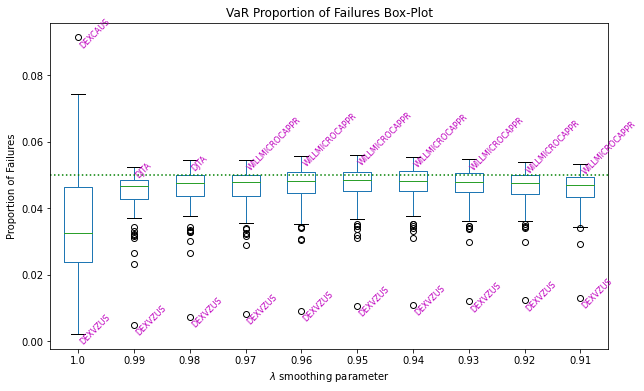

In [10]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
results['pof'].boxplot(ax=ax, grid=False)
ax.set_xticklabels([f"{1-c:.3}" for c in results['pof'].columns])
ax.set_xlabel('$\lambda$ smoothing parameter')
ax.set_title('VaR Proportion of Failures Box-Plot')
ax.set_ylabel('Proportion of Failures')
ax.axhline(1 - var, linestyle=':', color='g')
for x, c in enumerate(results['pof'].columns):
    for arg in [results['pof'][c].argmin(), results['pof'][c].argmax()]:
        
        y = results['pof'][c].iloc[[arg]]
        ax.annotate(y.index[0], xy=(x + 1, y[0]-.003), fontsize=8, c='m',
                    rotation=45)
plt.savefig(os.path.join(imgdir, 'pof.jpg'))
plt.show()